# Mellors MSDS 610 Final Project - Notebook 3: Parts 7-10

# Part 7: Executing with Live Data

## Part 7, Section 1: Loading Files and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
import joblib
import datetime

In [2]:
df_live = pd.read_csv("live_data.csv")

**Below:** I am importing my model and my feature engineering maps. The feature engineering maps are pickle files that I created when I was feature engineering and realized that the clean up of my sample would not specifically match the engineering on my training data. For instance, in my training data - which would have all the manufacturers - assigned them integers based on their frequency, but if I did that in my sample, it likely wouldn't contain all the manufactures and using frequency would change that. The idea is that I can create a pickle file that stores what number was assigned to each manufacturer in training and apply that correct number to the manufacturers that exist in the training data.

In [3]:
region_rank_map = joblib.load("region_rank_map.pkl")
state_rank_map = joblib.load("state_rank_map.pkl")
manufacturer_rank_map = joblib.load("manufacturer_rank_map.pkl")

In [4]:
xgb_model_live = joblib.load("xgb_price_predictor.pkl")

In [5]:
df_live.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            100 non-null    int64  
 1   url           100 non-null    object 
 2   region        100 non-null    object 
 3   region_url    100 non-null    object 
 4   price         100 non-null    int64  
 5   year          100 non-null    float64
 6   manufacturer  96 non-null     object 
 7   model         100 non-null    object 
 8   condition     53 non-null     object 
 9   cylinders     55 non-null     object 
 10  fuel          100 non-null    object 
 11  odometer      100 non-null    float64
 12  title_status  100 non-null    object 
 13  transmission  100 non-null    object 
 14  VIN           65 non-null     object 
 15  drive         71 non-null     object 
 16  size          20 non-null     object 
 17  type          79 non-null     object 
 18  paint_color   69 non-null     o

## Part 7, Section 2: Cleaning Data (with UDFs)

**Below:** I am developing 2 UDFs, one for the cleaning phase and one for the the engineering. I am using the "rules" tables I developed, along with my previous notebook, to ensure that this data is cleaned as close as possible to how the original set was cleaned. The comments (#) explain which part of the cleaning process the code lines are cleaning (and align with the cleaning table).

In [6]:
def clean_live_data(df):
    # Dropping Columns
    df.drop(columns=['id', 'model', 'url', 'region_url', 'VIN', 'image_url', 'description', 
                     'county', 'lat', 'long', 'size', 'posting_date', 'paint_color'], inplace=True)

    # Missing values
    df['year'] = df['year'].fillna(2011).astype(int)
    df.loc[df['year'] < 1940, 'year'] = 1940

    df['manufacturer'] = df['manufacturer'].fillna("unknown")
    df['fuel'] = df['fuel'].fillna("gas")
    df['odometer'] = df['odometer'].fillna(98045)  # Median value
    df['title_status'] = df['title_status'].fillna("clean")
    df['transmission'] = df['transmission'].fillna("automatic")

    # Creating "mileage" to use for NULLs in "condition"
    df['mileage'] = pd.cut(df['odometer'], bins=[0, 60000, 120000, float('inf')], labels=['low', 'medium', 'high'])
    df['condition'] = df.groupby(['year', 'mileage'])['condition'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "excellent"))

    # Imputing 'cylinders' based on 'type' and 'fuel'
    df['cylinders'] = df.groupby(['type', 'fuel'])['cylinders'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "unknown"))

    # Cylinder Mapping
    cylinder_mapping = {
        "3 cylinders": 3,
        "4 cylinders": 4,
        "5 cylinders": 5,
        "6 cylinders": 6,
        "8 cylinders": 8,
        "10 cylinders": 10,
        "12 cylinders": 12,
        "other": 0,
        "unknown": 4 }

    # Converting cylinders to numbers
    df['cylinders'] = df['cylinders'].map(cylinder_mapping).fillna(4).astype(int)

    # Imputing "drive" using "type" and "manufacturer"
    df['drive'] = df.groupby(['type'])['drive'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "fwd"))
    df['drive'] = df.groupby(['manufacturer'])['drive'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "fwd"))

    # Imputing "type" using "fuel" and "cylinders'
    df['type'] = df.groupby(['fuel', 'cylinders'])['type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "sedan"))

    return df

In [7]:
df_live_cleaned = clean_live_data(df_live)

C:\Users\kmell\AppData\Local\Temp\ipykernel_37784\3372651288.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['condition'] = df.groupby(['year', 'mileage'])['condition'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "excellent"))


In [8]:
df_live_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   region        100 non-null    object  
 1   price         100 non-null    int64   
 2   year          100 non-null    int32   
 3   manufacturer  100 non-null    object  
 4   condition     100 non-null    object  
 5   cylinders     100 non-null    int32   
 6   fuel          100 non-null    object  
 7   odometer      100 non-null    float64 
 8   title_status  100 non-null    object  
 9   transmission  100 non-null    object  
 10  drive         100 non-null    object  
 11  type          100 non-null    object  
 12  state         100 non-null    object  
 13  mileage       100 non-null    category
dtypes: category(1), float64(1), int32(2), int64(1), object(9)
memory usage: 9.7+ KB


In [9]:
def feature_engineer_live_data(df):
    # Creating 'age' feature from 'year'
    current_year = datetime.datetime.now().year
    df['age'] = current_year - df['year']
    df.drop(columns=['year'], inplace=True)  # Drop original year column

    # Creating 'luxury' feature
    luxury_brands = [
        'bmw', 'mercedes-benz', 'lexus', 'audi', 'cadillac', 
        'acura', 'infiniti', 'lincoln', 'volvo', 'jaguar', 
        'porsche', 'land rover', 'rover', 'alfa-romeo', 'tesla', 
        'ferrari', 'aston-martin']
    df['luxury'] = df['manufacturer'].apply(lambda x: 1 if x.lower() in luxury_brands else 0)

    # Loading the maps for region, manufacturer, and state & drop columns
    with open('region_freq_map.pkl', 'rb') as file:
        region_freq_map = pickle.load(file)
    df['region_encoded'] = df['region'].map(region_rank_map)
    
    with open('manufacturer_freq_map.pkl', 'rb') as file:
        manufacturer_freq_map = pickle.load(file)
    df['manufacturer_encoded'] = df['manufacturer'].map(manufacturer_rank_map)
    
    with open('state_freq_map.pkl', 'rb') as file:
        state_freq_map = pickle.load(file)
        df['state_encoded'] = df['state'].map(state_rank_map)

    df.drop(columns=['region', 'manufacturer', 'state'], inplace=True) 

    # Encode 'condition' as ordinal categories
    condition_mapping = {
        'new': 5, 'like new': 4, 'excellent': 3, 
        'good': 2, 'fair': 1, 'salvage': 0}
    df['condition_encoded'] = df['condition'].map(condition_mapping)
    df.drop(columns=['condition'], inplace=True)

    # Encode 'mileage' as ordinal categories
    mileage_map = {'low': 0, 'medium': 1, 'high': 2}
    df['mileage_encoded'] = df['mileage'].map(mileage_map)
    df.drop(columns=['mileage'], inplace=True)

    # Encode 'title_status' as ordinal categories
    title_status_mapping = {
        'clean': 5, 'rebuilt': 4, 'salvage': 3, 
        'lien': 2, 'missing': 1, 'parts only': 0}
    df['title_encoded'] = df['title_status'].map(title_status_mapping)
    df.drop(columns=['title_status'], inplace=True)

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=['fuel', 'transmission', 'drive', 'type'], drop_first=True)

    # Normalize 'odometer' using StandardScaler
    scaler = StandardScaler()
    df['odometer_encoded'] = scaler.fit_transform(df[['odometer']])
    df.drop(columns=['odometer'], inplace=True)

    return df

In [10]:
df_live_final = feature_engineer_live_data(df_live_cleaned)

**Below:** When I ran the above UDPs and model, I got an error stating that some expected columns did not exist. This was because, given my sample, those particular features weren't created (due to a lack of them in the sample). As such, I decided to manualy enter them with a value of "0".

In [11]:
df_live_final['fuel_electric'] = 0
df_live_final['type_bus'] = 0
df_live_final['type_convertible'] = 0
df_live_final['type_mini-van'] = 0
df_live_final['type_offroad'] = 0

In [12]:
df_live_final.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   price                 100 non-null    int64   
 1   cylinders             100 non-null    int32   
 2   age                   100 non-null    int32   
 3   luxury                100 non-null    int64   
 4   region_encoded        100 non-null    float64 
 5   manufacturer_encoded  100 non-null    float64 
 6   state_encoded         100 non-null    float64 
 7   condition_encoded     100 non-null    int64   
 8   mileage_encoded       100 non-null    category
 9   title_encoded         100 non-null    int64   
 10  fuel_gas              100 non-null    bool    
 11  fuel_hybrid           100 non-null    bool    
 12  fuel_other            100 non-null    bool    
 13  transmission_manual   100 non-null    bool    
 14  transmission_other    100 non-null    bool    
 15  drive_f

In [13]:
df_live_final.cylinders.value_counts()

cylinders
4    50
6    29
8    21
Name: count, dtype: int64

In [14]:
df_live_final.odometer_encoded.sample(5)

51   -0.892343
20    0.751789
91    0.327774
72    1.507280
65   -0.442698
Name: odometer_encoded, dtype: float64

In [15]:
df_live_final.mileage_encoded.info()

<class 'pandas.core.series.Series'>
RangeIndex: 100 entries, 0 to 99
Series name: mileage_encoded
Non-Null Count  Dtype   
--------------  -----   
100 non-null    category
dtypes: category(1)
memory usage: 364.0 bytes


## Part 7, Section 2: Executing Live Data on Saved Model

**Below:** I am using the the "get_booster" function on my model to ensure that my live data has the features it is expecting and in the right order. I had to use this, because when I ran my model I was getting errors that the columns were not in the order that they model expected them to be in. I then used "reindex" to make sure that the order matched the training data.

In [16]:
expected_features = xgb_model_live.get_booster().feature_names

In [17]:
df_live_final = df_live_final.reindex(columns=expected_features)

In [18]:
df_live_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   cylinders             100 non-null    int32   
 1   age                   100 non-null    int32   
 2   luxury                100 non-null    int64   
 3   region_encoded        100 non-null    float64 
 4   manufacturer_encoded  100 non-null    float64 
 5   condition_encoded     100 non-null    int64   
 6   fuel_electric         100 non-null    int64   
 7   fuel_gas              100 non-null    bool    
 8   fuel_hybrid           100 non-null    bool    
 9   fuel_other            100 non-null    bool    
 10  odometer_encoded      100 non-null    float64 
 11  title_encoded         100 non-null    int64   
 12  transmission_manual   100 non-null    bool    
 13  transmission_other    100 non-null    bool    
 14  drive_fwd             100 non-null    bool    
 15  drive_r

In [19]:
predictions = xgb_model_live.predict(df_live_final)

**Below:** I am adding a new column "predicted_price" that adds the predictions into the dataframe, and I am reinserting the "price" column (which had to be removed when I was reindexing the file names, because the model wasn't expecting that column.

In [20]:
df_live_final = df_live_final.assign(predicted_price=predictions, price=df_live['price'])

In [21]:
df_live_final.predicted_price.sample(5)

98     9728.694336
74     3728.363037
73    10215.066406
78     8974.831055
76     6681.139648
Name: predicted_price, dtype: float32

In [22]:
df_live_final.head()

,cylinders,age,luxury,region_encoded,manufacturer_encoded,condition_encoded,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,...,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,state_encoded,mileage_encoded,predicted_price,price
0,4,15,0,58.0,33.0,4,0,True,False,False,...,False,False,True,False,False,False,2.0,2,5897.312012,3900
1,8,10,0,49.0,1.0,2,0,False,False,False,...,False,True,False,False,False,False,2.0,0,64838.515625,68788
2,6,7,0,56.0,1.0,2,0,True,False,False,...,True,False,False,False,False,False,31.0,0,24135.314453,19990
3,6,25,0,38.0,9.0,1,0,True,False,False,...,False,False,False,False,True,False,18.0,2,2173.812256,2900
4,4,13,0,117.0,9.0,3,0,True,False,False,...,False,False,True,False,False,False,4.0,2,12238.546875,10295


# Part 8: Storing Predictions

In [23]:
from sqlalchemy import create_engine

In [24]:
host = r'127.0.0.1' 
db = r'MSDS610' 
user = r'postgres' 
pw = r'postgres' 
port = r'5432'
schema = r'cleaned'

In [25]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [26]:
sql = "SELECT tables.table_name FROM information_schema.tables WHERE table_schema = '" + schema + "' ORDER BY 1;"
sql

"SELECT tables.table_name FROM information_schema.tables WHERE table_schema = 'cleaned' ORDER BY 1;"

In [27]:
tbl_df = pd.read_sql(sql, db_conn, index_col=None)

In [28]:
table_name = r'df_live_preds'

In [29]:
df_live_final.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema="analytic", chunksize=1000, method='multi')

100

![pgAdmin Screenshot](msds_610_final_project_df_preds_img.png)

# Part 9: Insights

In [30]:
import xgboost as xgb

**Below:** I am looking at the Mean Absolute Error and R2 score to see how well my model performed.

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [32]:
y_actual = df_live_final['price']
y_pred = df_live_final['predicted_price']

In [33]:
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

In [34]:
print(mean_absolute_error(y_actual, y_pred))
print(r2_score(y_actual, y_pred))

6155.773936767579
0.41893261671066284


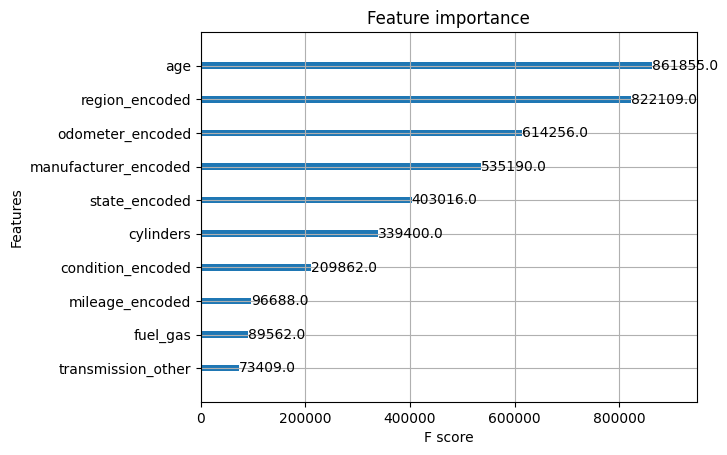

In [35]:
xgb.plot_importance(xgb_model_live, max_num_features=10)
plt.show()

**Summary** 
We can see that when the model was ran on my raw data, it performed much poorer than I anticipated (especially given the fact that it did rather well in testing and validation). On the "live" data, the model predictions were off from the actual prices an average of 8,715 dollars, which is twice as big as the average from the testing and validation phase. Additionally, the predictive power is really low, with a 0.42 (compared to my testing and validation of 0.74). I rechecked the important features of my model, to make sure that it was processing the "live" data the same as the training data, which we can see it is. This tells me, given the low prediction power, that for some reason the "live" data is expecting different features to be the most important for prediction (which doesn't make sense to me, something went wrong with processing the "live data).

In terms of the scenario, this is not a good live model (although, after testing and validation, I would have recommened the model for live deployment). Given that the model is off by more than 6,000 dollars, I don't think that it would produce viable prices for the company; certainly not within range. The model would either over price (making the car as an unviable option of customers) or under price (cutting into the organizations profits). Because of the validation and testing phases working well, I imagine that something went wrong during the "live" data processing (I wasn't able to figure it out, I explain more in the next section).

# Part 10: Summary

First, I want to say that this was a very valuable class, it was definitely interesting learning how to take the data through a data pipeline and the importance of data storage and collection. I thought that this assignment was really good at testing our capabilities with handling, storing, and processing the data. Personally, I really enjoyed the feature engineering part of the data processing (I understand why it wouldn't be everyone's favorite); I enjoyed it because it really had me thinking outside of the box, while I did create 3 new features, which I expected to have some predictive power in the model, only 2 of them showed up in the top 10 most important, and one did not, although, one of my features "age", was the number one predictor in my model, so that was really cool to see. Additionally, I really enjoyed testing different models just to compare - at baseline parameters - computational needs and accuracy. In the end, I actually didn't opt for the model that performed best at the baseline (RF), mainly because I was convinced that a more computationally-capable model (XGB) could be tuned to better perform; which I was correct, so I was able to get my parameterized XGB to perform better than my RF, and I definitely felt a sense of personal accomplishment there.

However, my feeling of personal accomplishment was soon replaced with confusion and personal frustration when it came to "deploying" my model on the live data. First, creating the UDFs, while easier given that I created the rule tables, was quite tedious and I am prone to making small errors, so I had to be really sure that it was all correct (although, even now, I am not sure it is), and had to keep adjusting to fix errors with the UDFs. Once I was able to get UDFs that didn't create errors, I then went to test my model and, it functioned rather poorly. I attempted a number of things (which I tested within the notebooks and seperate notebooks, and ultimately removed when they didn't work), such as reducing the initial dataframe to only the top 10 important features (it actually performed slightly better on the live data than my originally processed data, with a 0.30 r2 score). I also made a copy of my data cleaning and engineering notebook and manually went through each step to with the "live" data (to usurp the UDFs) and that didn't help either, there were issues, like I mentioned above, with certain columns not generating because the feature engineering didnt create them due to a lack of entries. Even now, I am unsure where the issue is. I also addressed how I was assigning the integer values for my pickled features (initially I was just using frequency, but then used ranking with frequency). I can only imagine that the issue must reside within either the data processing, or the mapping (pickle) files that I used to generate the integers for some of the features -- I think it might be that, because  all three of the mapped features are in the top 5 features my original model used to make predictions. 

Overall, while I am disappointed with my "live" prediction outcomes, I am very pleased with my testing, validation, and model. I also found it really cool to learn abit about using SQL, something that I think I am going to be practicing in my spare time. 